# Project 4 Report

This is my report by Project 4 of the Machine Learning Engineer Nanodegree - **Teach a Smartcab How to Drive**. In this project I used reinforcement learning techniques to teach an engine how to play a simple game of reaching a destination on a grid-like world given some restrictions. The project description can be found [here](https://classroom.udacity.com/nanodegrees/nd009/parts/0091345409/modules/540405889375461/lessons/5404058893239847/concepts/54440204820923), and my code for the project is on [this github repo](https://github.com/lmurtinho/machine-learning/tree/my_projects/projects/smartcab).

## Task 0: Implementing a Perfect Agent

Although this is not a requirement, it is relatively simple, given the inputs, to define a set of rules that result in an agent that will always take the right action. The next move is given by the `self.next_waypoint` variable inside the `update` method of our agent; the only thing to do is take care that the agent will only perform the next move when it can, following the right-of-way rules in the project description, reproduced below:

>US right-of-way rules apply: On a green light, you can turn left only if there is no oncoming traffic at the intersection coming straight. On a red light, you can turn right if there is no oncoming traffic turning left or traffic from the left going straight.

So, a simple set of rules should suffice to make our agent perfect:

In [1]:
# this is a method of an Agent object
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # The next best move is given by the planner
    action = self.next_waypoint
    
    # On a red light, the agent can only turn right, and even so only if:
    # - no oncoming traffic is going left
    # - no traffic from the left is going forward
    if inputs['light'] == 'red':
        if (action != 'right') or (inputs['oncoming'] == 'left') or (inputs['left'] == 'forward'):
            action = None
    
    # On a green light, the agent cannot turn left if there is
    # oncoming traffic going forward
    elif inputs['oncoming'] == 'forward' and action == 'left':
        action = None

The "perfect agent" version of the code is stored in [this Github commit](https://github.com/lmurtinho/machine-learning/tree/c743b492c1f1b033ff0724fece542e6a01901540).

However, the goal of the project is to build an agent that can *learn these rules by itself*. Let's follow the project's rubric and see how it goes.

## Task 1: Implement a Basic Driving Agent

According to the project's instructions, the basic driving agent should "produce some random move/action." That's easy enough: 

In [2]:
import random

def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # Do something random
    action = random.choice(['right', 'left', 'forward', None])

With this strategy, the agent may reach its destination on time, but only if it gets lucky. When the deadline is not enforced, the agent will eventually get there - but it can take a long time, since it's not at all actually aiming for it. The agent also gets lots of penalties for incurring in illegal moves, such as trying to go forward when the light is red. 

The "random agent" version of the code is stored in [this Github commit](https://github.com/lmurtinho/machine-learning/tree/bbdc04d70cc31e2b8071bcf8356e9b752aed29ef).

From this behavior (and the behavior of the perfect agent implemented before) we can begin to think about what information needs to be in the state for the agent to learn the appropriate behavior: it needs to know where the destination is, as well as information about its surroundings (if the light is green or red and whether right-of-way rules imply it should stay put). 

## Task 2: Identify and Update State

The following information is available for the agent at each update:

- *Light*: whether the light is red or green. As mentioned above, a green light means the agent can perform the next action, with the possible exception of a left turn, while a red light means the agent should stay put, with the possible exception of a right turn. So, it is important to add the light to the state.
- *Oncoming*: whether there is oncoming traffic, and which direction it is going. As mentioned above, oncoming traffic may mean the agent cannot turn left or right, so this information needs to be in the state as well.
- *Right*: whether there is traffic from the right of the agent, and which direction it is going. Right-of-way rules don't mention traffic to the right at any point, so this is unnecessary information that doesn't need to be in the state for the agent to learn the optimal policy.
- *Left*: whether there is traffic from the left of the agent, and which direction it is going. Traffic from the left going straight means the agent cannot turn right on a red light, so this needs to be in the state.
- *Next waypoint*: the direction the agent should go to reach the destination. Without this information, the agent does not know where to go next and might as well wonder around randomly, so this needs to go in the state.
- *Deadline*: how much time the agent has left to reach its destination. At first, I would say this is not meaningful information for the agent, since it doesn't change right-of-way rules nor the best route. I thought about adding it to the state anyway, but this would mean a large increase in the number of possible states. Using only `light` (red or green), `oncoming` (None, left, right, or forward), `left` (None, left, right, or forward) and `next_waypoint` (left, right, or forward), we have $2\times4\times4\times3=96$ possible states. Adding `deadline` would mean multiplying this number by 50, if not more. So I'll keep `deadline` off my state for now.

There is the possibility of combining inputs to create a state. Maybe I could define the state in such a way that the allowed actions would be immediately available for the agent; for instance, I could come up with a `turn_right` variable that would check if the agent can turn right, and add that variable to the state. At least for now, though, I'd rather see how the agent deals with the "raw" variables; I can tweak the state later to try and get the agent to find the optimal policy.  

In [3]:
import random

def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)
    
    # update state
    self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                  self.next_waypoint)
    
    # Do something random
    action = random.choice(['right', 'left', 'forward', None])

The version of the code with a state is stored in [this Github commit](https://github.com/lmurtinho/machine-learning/tree/f5a6241f8d29a6d53e98ecc79715cd69947ad348).

## Task 3: Implement Q-Learning
In this step our agent begins to learn from its actions. The project specifically says to "pick the best action available from the current state based on Q-values," so I'll leave the exploration-exploitation dilemma for the next section.

### Deciding on the Appropriate Q-learning Function 

The general form of the $Q$-function is: 

$Q(s, a) = R(s) + \gamma\underset{s'}\sum T(s,a,s')\underset{a'}{\operatorname{max}}Q(s', a')$

That is, the $Q$-value for a given `(state, action)` pair is the the reward for that state, $R(s)$, plus the discounted expected value of $Q$ for the next state the agent lands in, considering the transition function $T(s,a,s') = \Pr(s' \mid s,a)$ (the probability of landing on state $s'$ coming from state $s$ and performing action $a$) and that, whatever $s'$ is, the agent will maximize $Q$ from there on.

The $Q$-learning update function is given by:

$\hat{Q}_t(s, a) = (1 - \alpha_t)\hat{Q}_{t-1}(s, a) + \alpha_t(r + \gamma\underset{a'}{\operatorname{max}}\hat{Q}_{t-1}(s', a'))$

That is, our estimate of the $Q$-value for the `(state, action)` pair is updated with the learning rate ($\alpha_t$, which varies over time) by the observed reward ($r$) and our previous estimate of the Q-value for the observed next state ($s'$), discounted by the discount factor ($\gamma$) and considering the agent will pick the action $a'$ that maximizes $Q$ from the next state on.

However, in this case there's no need to worry about the future state, since the agent gets an immediate reward for doing the right thing. According to the project description:

>The smartcab gets a reward for each successfully completed trip. A trip is considered “successfully completed” if the passenger is dropped off at the desired destination (some intersection) within a pre-specified time bound (computed with a route plan).

>It also gets a smaller reward for each correct move executed at an intersection. It gets a small penalty for an incorrect move, and a larger penalty for violating traffic rules and/or causing an accident.

So, even though the larger reward is only reaped once the agent reaches its destination, there are smaller rewards for following the correct path, and penalties for not doing so. This should be enough for the agent to learn the best policy.

Granted, ignoring the agent's future decisions means I'm not using some information that could be of help. But the upside is a simplification of the problem: it's as if the agent is playing a 1-round game over and over, with immediate rewards for immediate actions. I expect this simplification more than compensates ignoring long-term rewards in this particular setting.

### Q-learning implementation

This means I won't actually bother with keeping track of the state the agent ends up in after performing an action (or, to be more technical, I'm setting the discount factor $\gamma$ to zero). My update function will then simply be $\hat{Q}_t(s, a) = (1 - \alpha_t)\hat{Q}_{t-1}(s, a) + \alpha_tr$.

Here's what I'll do:
- Initialize `agent.qvals` as an empty dictionary and `agent.time` as 0 when the agent is initialized. 
- Define a `best_action()` method that takes a state and returns the best action (or one of the best actions) given the current Q-values:

In [4]:
# agent method
def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or one of the best actions, given a state.
    """
    # get all possible q-values for the state 
    all_qvals = {action: self.qvals.get((state, action), 0)
                 for action in self.possible_actions}        

    # pick the actions that yield the largest q-value for the state
    best_actions = [action for action in self.possible_actions 
                    if all_qvals[action] == max(all_qvals.values())]

    # return one of the best actions at random
    return random.choice(best_actions)  

- In the `update()` agent method: 
    - increment the time by 1
    - set the learning rate as 1/time
    - pick the action using `best_action()`
    - update the value for the `(state, action)` pair in the `qvals` with the reward.

In [5]:
# agente method
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)

    # update time and learning rate
    self.time += 1
    learn_rate = 1.0 / self.time

    # Update state
    self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                  self.next_waypoint)

    # Pick the best known action
    action = self.best_action(self.state)

    # Execute action and get reward
    reward = self.env.act(self, action)

    # Update the q-value of the (state, action) pair
    self.qvals[(self.state, action)] = \
        (1 - learn_rate) * self.qvals.get((self.state, action), 0) + \
        learn_rate * reward

This version of the code is stored in [this Github commit](https://github.com/lmurtinho/machine-learning/tree/0a81431628b75a021c2698c2f2897c0032d39db7).

## Task 4: Enhance the Driving Agent

The last task, according to the project description, is:

> Apply the reinforcement learning techniques you have learnt, and tweak the parameters (e.g. learning rate, discount factor, action selection method, etc.), to improve the performance of your agent. Your goal is to get it to a point so that within 100 trials, the agent is able to learn a feasible policy - i.e. reach the destination within the allotted time, with net reward remaining positive.

This goal is reached with the implementation presented above. Although there are instances in which, with 90+ trials, the agent will pick a wrong action from time to time, in my tests it rarely failed to reach the destination after 60+ trials.

But that doesn't mean the agent can't be modified, and it certainly means it can be improved. According to [one of the videos](https://www.udacity.com/course/viewer#!/c-ud728-nd/l-5446820041/m-634899064) in the Reinforcement Learning course, there are three characteristics that can change a Q-learning algorithm:

- How Q-values are initialized
- How the learning rate decays
- How the action is picked

I'll change each one of these three characteristics at a time, and then I'll tackle everything at once to see it I can get a better learning agent.

### Baseline Comparison

Before modifying my agent, I need to define what a "better" agent would look like. Some ideas come to mind:

- A better agent would have a larger sum of rewards over time
- A better agent would reach its destination more often
- A better agent would learn faster
- A better agent would make fewer mistakes
- A better agent would explore as much of the world as possible

Some of these may be redundant in this setting: more rewards, for instance, probably means fewer mistakes, and vice-versa. Still, I think this is a good starting point. So I'll keep track of the following variables:

- `reward_sum`: the sum of rewards for an agent over a simulation
- `disc_reward_sum`: the sum of rewards *discounted over time*, so that an agen that heaps larger rewards faster (i.e. learns faster) will have a larger `disc_reward`
- `n_dest_reached`: the number of times the agent has reached its destination
- `last_dest_fail`: the most recent trial in which the agent did not reach its destination
- `sum_time_left`: the sum over all trials of the steps the agent still had available when it reached its destination (0 if it never reached it)
- `n_penalties`: the number of penalties incurred by the agent
- `last_penalty`: the most recent trial in which the agent received a penalty
- `len_qvals`: how many Q-values are mapped in the agent's Q-function - that is, how many `(state, action)` pairs it visited during the simulation

Here are the basic statistics for my baseline agent, after running 100 simulations with 100 trials each:

In [12]:
import pandas as pd

df_original = pd.DataFrame.from_csv("original_agent_results.csv")
df_original.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty,len_qvals
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2218.360000,76.857365,99.240000,16.370000,1747.400000,31.250000,92.920000,49.400000
std,40.326764,21.534641,1.006243,29.570889,67.273751,17.244162,5.864945,6.780841
min,2124.000000,40.248500,92.000000,0.000000,1516.000000,20.000000,72.000000,34.000000
25%,2185.875000,61.049489,99.000000,0.000000,1710.000000,25.750000,90.000000,44.000000
50%,2217.750000,73.482848,99.000000,1.000000,1754.500000,28.000000,94.000000,49.000000
75%,2244.875000,87.325426,100.000000,11.250000,1789.500000,32.000000,98.000000,54.000000
max,2313.500000,150.830346,100.000000,100.000000,1888.000000,162.000000,100.000000,68.000000


(The csv file with the results described above is [here](https://github.com/lmurtinho/machine-learning/blob/63dbdf6cef703a2ea8e5839bcd400bc3f46f7aaf/projects/smartcab/original_agent_results.csv).)

`reward_sum`, `disc_reward_sum`, `sum_time_left`, `n_penalties` and `len_qvals` will make more sense when compared with the results from other agents, but there's already something to be said about the other variables:

- In all simulations, more than 50% of destinations are reached on time, and in most simulations only one destination is not reached. So the primary goal of getting to the destination is being met.
- For most simulations, after 35 trials there is no more failures to reach a destination. But there are some simulations in which later trials result in failures.
- The agent keeps getting penalties (for an incorrect or invalid move) even quite late in most simulations - a sign that the earlier trials could use more exploration and less exploitation.

Overall, this still seems like a solid learning agent, but let's see if some tweaks can make it better.

### Changing Initial Q-Values

One Q-learning implementation briefly discussed in the Reinforcement Learning lessons for this project is "optimism in the face of uncertainty". The idea is that high initial Q-values (implying an "optimistic" agent in the sense that it initially believes all possible actions will yield excellent rewards) lead to an explorative agent, because it will delay exploiting familiar paths, since those will end up with lower Q-values than its initial estimate.

All it takes for my original agent to become optimistic is changing the value it gets when the `(state, action)` pair is not yet a key in `qvals`:

In [26]:
import random

def best_action(self, state):
    """
    Returns the best action (the one with the maximum Q-value)
    or one of the best actions, given a state.
    """        
    # get all possible q-values for the state
    # (be optimistic in the face of uncertainty)
    all_qvals = {action: self.qvals.get((state, action), 5)
                 for action in self.possible_actions}        

    # pick the actions that yield the largest q-value for the state
    best_actions = [action for action in self.possible_actions 
                    if all_qvals[action] == max(all_qvals.values())]

    # return one of the best actions at random
    return random.choice(best_actions)        


Instead of getting a 0 for previously unknown `(state, action)` pairs, the agent now gets a 5, which is more than even a correct move would yield as reward. So, it has more of an incentive to investigate new paths.

I also changed the Q-learning update function, as below:

In [27]:
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)

    # update time and learning rate
    self.time += 1
    learn_rate = 1.0 / self.time

    # Update state
    self.state = (inputs['light'], inputs['oncoming'], inputs['left'],
                  self.next_waypoint)

    # Pick the best known action
    action = self.best_action(self.state)

    # Execute action and get reward
    reward = self.env.act(self, action)
    if reward < 0:
        self.n_penalties += 1
    self.reward_sum += reward
    self.disc_reward_sum += reward / (self.time/10.0)

    # Update the q-value of the (state, action) pair
    # be optimistic in the face of uncertainty
    self.qvals[(self.state, action)] = \
        (1 - learn_rate) * self.qvals.get((self.state, action), 5) + \
        learn_rate * reward

These are the results for running 100 simulations of 100 trials each with this optimistic agent:

In [7]:
df_optimistic = pd.DataFrame.from_csv("optimistic_agent_results.csv")
df_optimistic.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1406.150000,25.556748,55.280000,98.230000,784.930000,998.800000,99.970000
std,313.708878,13.358804,13.900134,2.684994,224.259106,166.474374,0.222702
min,410.000000,-4.317224,17.000000,88.000000,233.000000,569.000000,98.000000
25%,1285.250000,17.793487,48.000000,97.750000,650.750000,872.750000,100.000000
50%,1465.750000,23.965617,57.000000,99.000000,773.000000,986.500000,100.000000
75%,1632.125000,32.683377,64.000000,100.000000,944.500000,1126.750000,100.000000
max,1993.000000,93.368344,93.000000,100.000000,1523.000000,1450.000000,100.000000


(The csv file is [here](https://github.com/lmurtinho/machine-learning/blob/5cd532b2a13dbf593a6e3605e4594bfa81d11018/projects/smartcab/optimistic_agent_results.csv).)

A clearly *worse* result than the original agent! The next modification will help explain why.

### Modifying the Learning Rate Decay

My `learn_rate` variable is the inverse of my `time` variable - that is, when `time` is 1, `learn_rate` is 1/1; when `time` is 2, `learn_rate` is 1/2, and so on.

But that means that the learning rate goes down *even for the* `(state, action)` *pairs not yet visited*, which greatly affects how states are updated. For example, suppose a learning agent with optimistic initialization of Q-values such that all `(state, action)` pairs initially map to a Q-value of 3. Let's also assume that the true reward for action x is -1 for both states A and B. If A is the initial state and x is the first action taken, and assuming a learning rate that is the inverse of time, the `(A, x)` Q-value will be updated to $(1 - 1)\times3 + 1\times-1 = -1$. If state B is the state at time 2 and action x is taken again, however, the `(B, x) ` Q-value will be updted to $(1-1/2)\times3 + (1/2)\times-1 = 1$. So the Q-value will be quite different for both `(state, action)` pairs, even though the agent visited them both only once.

To solve this, let's change `learn_rate` to take into account the agent's experience *in a given* `(state, action)` *pair*:

In [10]:
# self.visits is initialized as empty dict
def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)

    # Update state
    self.state = (inputs['light'], inputs['oncoming'], 
                  inputs['left'], self.next_waypoint)

    # update time
    self.time += 1

    # Pick the best known action
    action = self.best_action(self.state)

    # update learning rate according to 
    # number of times (state, action) pair has been seen
    qval_pair = (self.state, action)
    self.visits[qval_pair] = self.visits.get(qval_pair, 0) + 1
    learn_rate = 1.0 / self.visits[qval_pair]

    # Execute action and get reward
    reward = self.env.act(self, action)
    if reward < 0:
        self.n_penalties += 1
    self.reward_sum += reward
    self.disc_reward_sum += reward / (self.time/10.0)

    # Update the q-value of the (state, action) pair
    self.qvals[qval_pair] = \
        (1 - learn_rate) * self.qvals.get(qval_pair, 5) + \
        learn_rate * reward 

And let's see the results for the optimistic agent with this new learning rate decay:

In [11]:
df_optim_new_learn_rate = pd.DataFrame.from_csv("optim_new_learn_rate_agent_results.csv")
df_optim_new_learn_rate.describe()

,reward_sum,disc_reward_sum,n_dest_reached,last_dest_fail,sum_time_left,n_penalties,last_penalty
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2217.265000,70.084863,98.930000,19.860000,1731.900000,37.040000,93.920000
std,44.469514,14.477370,1.017573,31.017434,80.620886,5.572153,6.017953
min,2126.000000,44.277556,95.000000,0.000000,1541.000000,25.000000,69.000000
25%,2182.250000,58.903426,98.750000,0.000000,1678.500000,34.000000,91.000000
50%,2211.500000,69.294894,99.000000,1.000000,1725.000000,36.500000,95.000000
75%,2244.750000,78.495404,100.000000,34.750000,1784.000000,39.000000,99.000000
max,2338.000000,130.943204,100.000000,98.000000,1941.000000,75.000000,100.000000


## Results

The last task, according to the project description, is:

> Apply the reinforcement learning techniques you have learnt, and tweak the parameters (e.g. learning rate, discount factor, action selection method, etc.), to improve the performance of your agent. Your goal is to get it to a point so that within 100 trials, the agent is able to learn a feasible policy - i.e. reach the destination within the allotted time, with net reward remaining positive.

This goal is reached with the implementation presented above. Although there are instances in which, with 90+ trials, the agent will pick a wrong action from time to time, in my tests it never failed to reach the destination after 60+ trials.

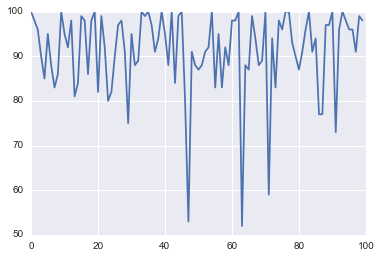

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(df_original['last_penalty'])

#for column in df_original.columns:
#    sns.boxplot(x=column, data=df_original)
#    plt.show()